In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import h5py

## Task 1: CNNs for Galaxy Classification

In [2]:
# create data folder if it does not exist
import os
os.makedirs("data", exist_ok=True)

import urllib.request
_, msg = urllib.request.urlretrieve(
    "http://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5", 
    "data/Galaxy10.h5"
)

In [3]:
label_names = [
    'Disk, Face-on, No Spiral',
    'Smooth, Completely round',
    'Smooth, in-between round',
    'Smooth, Cigar shaped',
    'Disk, Edge-on, Rounded Bulge',
    'Disk, Edge-on, Boxy Bulge',
    'Disk, Edge-on, No Bulge',
    'Disk, Face-on, Tight Spiral',
    'Disk, Face-on, Medium Spiral',
    'Disk, Face-on, Loose Spiral'
]
n_classes = len(label_names)

# To get the images and labels from file
with h5py.File('data/Galaxy10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])
images = images.astype(np.float32)

# comply to (batch, channel, height, width) convention of pytorch
images = np.moveaxis(images, -1, 1)  
# convert to torch
images = torch.from_numpy(images)
labels = torch.from_numpy(labels)

print(f'{images.shape=}, {labels.shape=}')

images.shape=torch.Size([21785, 3, 69, 69]), labels.shape=torch.Size([21785])


### (a)

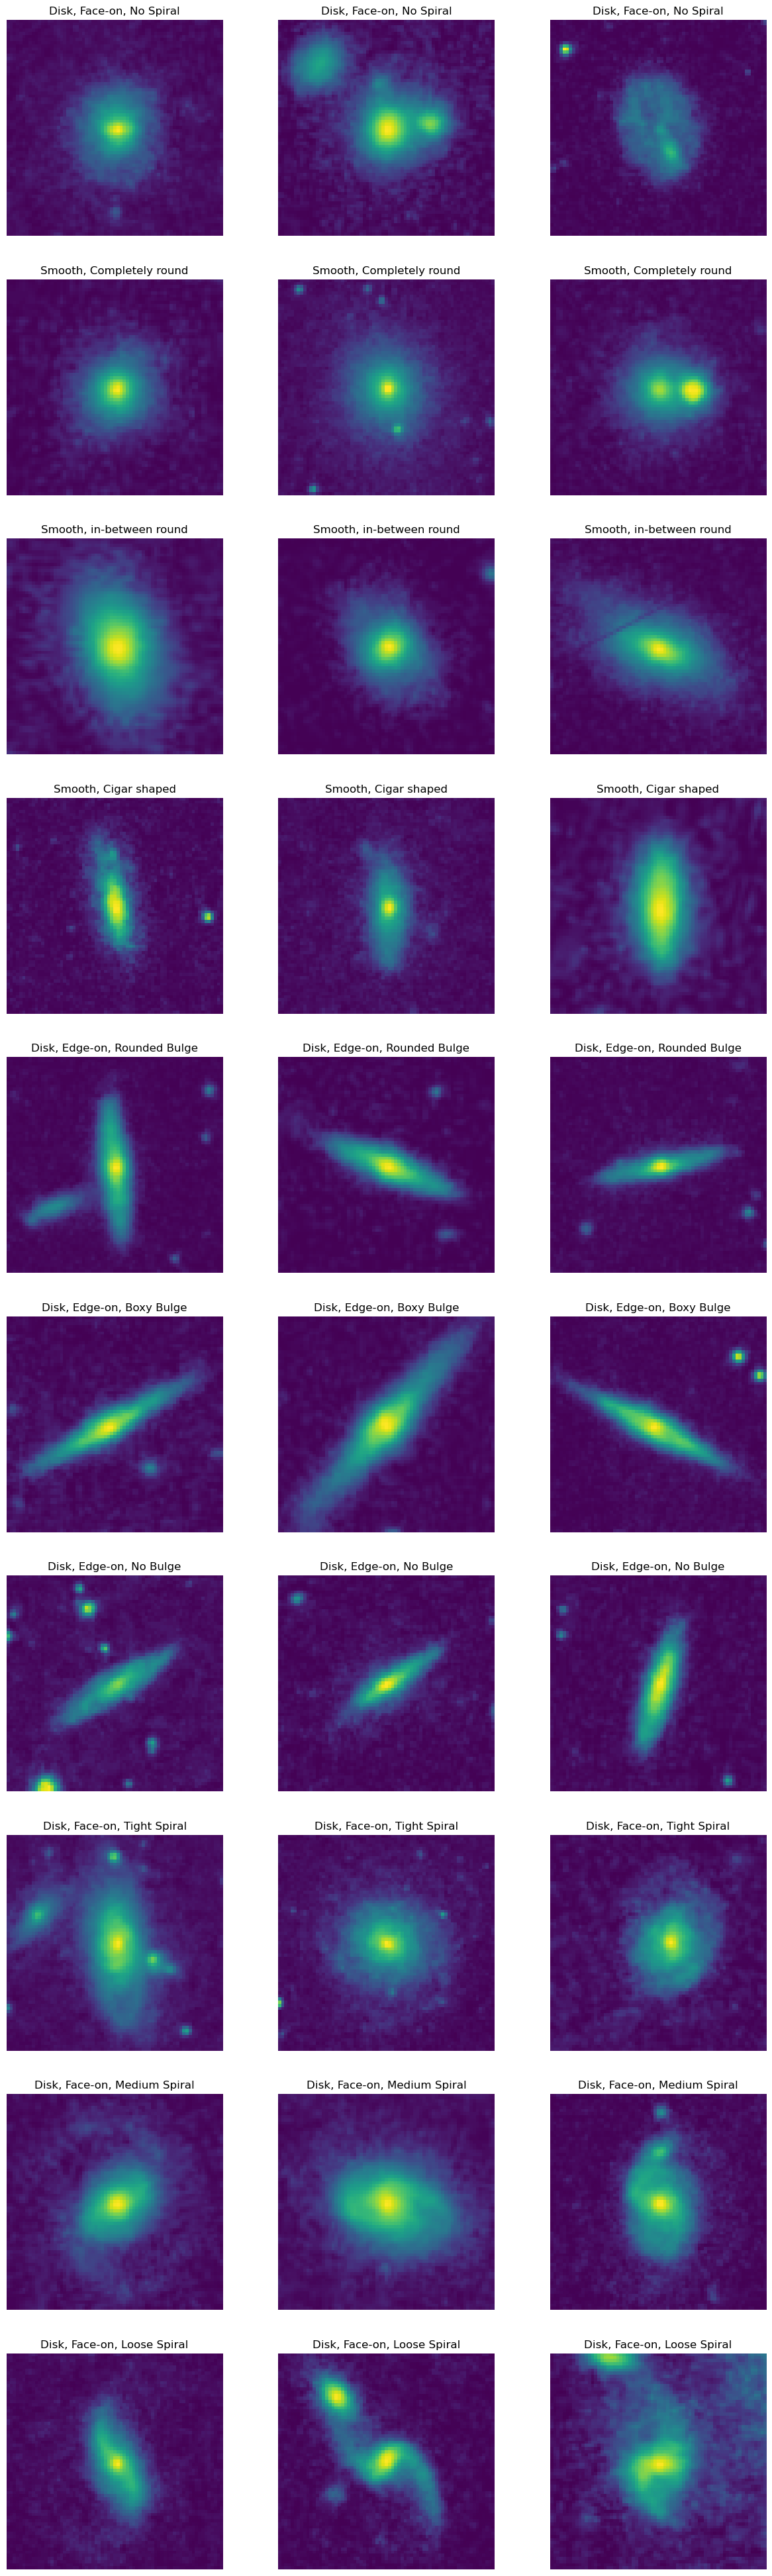

In [4]:
# TODO: plot three samples of each class
fig, ax = plt.subplots(nrows=10, ncols=3, figsize=(15, 50))
for i in range(n_classes):
    ind = (labels==i).nonzero(as_tuple=True)[0][0:3]
    for j in range(3):
        ax[i][j].imshow(images[ind[j]][0])
        ax[i][j].set_title(f'{label_names[i]}')
        ax[i][j].set_axis_off()

In [5]:
from torchvision.transforms import Normalize

# TODO: Normalize the images
mean = [images[:, 0, :, :].mean(), images[:, 1, :, :].mean(), images[:, 2, :, :].mean()]
std = [images[:, 0, :, :].std(), images[:, 1, :, :].std(), images[:, 2, :, :].std()]
images_normalized = Normalize(mean, std)(images)
print(f'{mean=}, {std=}')

mean=[tensor(27.7014), tensor(23.8240), tensor(18.1425)], std=[tensor(37.5412), tensor(31.3756), tensor(26.3283)]


In [6]:
# TODO: Split the data and create tensordatasets and data loaders:
ind = np.random.permutation(images.shape[0])
images_shuffled = images[ind]
labels_shuffled = labels[ind]

fraction = images_shuffled.shape[0]//10

test_set = TensorDataset(images_shuffled[0: fraction], labels_shuffled[0: fraction])
val_set = TensorDataset(images_shuffled[fraction: 2*fraction], labels_shuffled[fraction: 2*fraction])
train_set = TensorDataset(images_shuffled[2*fraction:], labels_shuffled[2*fraction:])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=True)

### (b)

In [7]:
#TODO: implement a small CNN as specified on the sheet
from torch import nn

class GalaxyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            # in 3*69*69
            nn.Conv2d(
                # out 8*65*65
                in_channels=3,
                out_channels=8,
                kernel_size=5,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # out 8*32*32
        )
        self.conv2 = nn.Sequential(
            # in 8*32*32
            nn.Conv2d(
                # out 16*28*28
                in_channels=8,
                out_channels=16,
                kernel_size=5,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # out 16*14*14
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*14*14, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=10),
        )

        self.CNN = nn.Sequential(
            self.conv1,
            self.conv2,
            self.fc,
        )

    def forward(self, x):
        x = self.CNN(x)
        return x

### 

### (c) + (d) + (e)

In [8]:
# TODO: Instantiate the model, optimizer and criterion
model = GalaxyCNN()

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

train_losses = []
train_accs = []
val_losses = []
val_accs = []

# TODO: Implement the training loop, validating after every epoch, and make the requested plots.

def train(model):
    losses = []
    correct = []

    for data in train_loader:
        # get the inputs, labels
        inputs, lbs = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, lbs)

        losses.append(loss.detach().numpy())
        for event in (lbs == outputs.argmax(dim=1)).detach().numpy():
            correct.append(event)

        loss.backward()
        optimizer.step()
    
    avg_loss = np.mean(np.array(losses))
    accuracy = np.mean(np.array(correct))
        
    return avg_loss, accuracy

def validate(model):
    losses = []
    correct = []

    #TODO: Implement the validation loop

    for data in val_loader:
        # get the inputs, labels
        inputs, lbs = data

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, lbs)
        
        losses.append(loss.detach().numpy())
        for event in (lbs == outputs.argmax(dim=1)).detach().numpy():
            correct.append(event)
    
    avg_loss = np.mean(np.array(losses))
    accuracy = np.mean(np.array(correct))
    print(f'{accuracy=:.2f}, {avg_loss=:.2e}')

    if len(val_losses) == 0 or avg_loss < min(val_losses):
        torch.save(model, 'model/best_model')
    return avg_loss, accuracy


for epoch in range(100):
    # TODO: Implement the training loop, validating after every epoch and a visialization of the loss curves
    train_loss, train_acc = train(model)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    val_loss, val_acc = validate(model)
    val_losses.append(val_loss)
    val_accs.append(val_acc)



accuracy=0.58, avg_loss=1.09e+00
accuracy=0.67, avg_loss=1.02e+00
accuracy=0.72, avg_loss=7.77e-01
accuracy=0.71, avg_loss=7.86e-01
accuracy=0.73, avg_loss=7.62e-01
accuracy=0.73, avg_loss=7.20e-01
accuracy=0.74, avg_loss=8.68e-01
accuracy=0.74, avg_loss=8.46e-01
accuracy=0.74, avg_loss=8.12e-01
accuracy=0.75, avg_loss=8.93e-01
accuracy=0.73, avg_loss=9.26e-01
accuracy=0.73, avg_loss=1.03e+00
accuracy=0.73, avg_loss=1.02e+00
accuracy=0.71, avg_loss=1.04e+00
accuracy=0.74, avg_loss=1.08e+00
accuracy=0.73, avg_loss=1.19e+00
accuracy=0.73, avg_loss=1.30e+00
accuracy=0.72, avg_loss=1.41e+00
accuracy=0.70, avg_loss=1.52e+00
accuracy=0.70, avg_loss=1.65e+00
accuracy=0.70, avg_loss=1.84e+00
accuracy=0.71, avg_loss=1.66e+00
accuracy=0.72, avg_loss=2.34e+00
accuracy=0.71, avg_loss=1.97e+00
accuracy=0.71, avg_loss=2.20e+00
accuracy=0.71, avg_loss=2.00e+00
accuracy=0.71, avg_loss=2.11e+00
accuracy=0.71, avg_loss=1.99e+00
accuracy=0.72, avg_loss=1.98e+00
accuracy=0.71, avg_loss=2.07e+00
accuracy=0

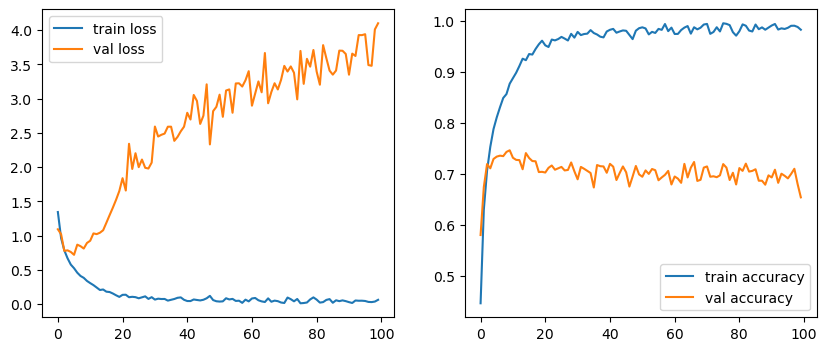

In [9]:
plt.rcParams["figure.figsize"] = (10,4)
plt.subplot(121)
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()

plt.subplot(122)
plt.plot(train_accs, label='train accuracy')
plt.plot(val_accs, label='val accuracy')
plt.legend()

### (e) continued

<Axes: >

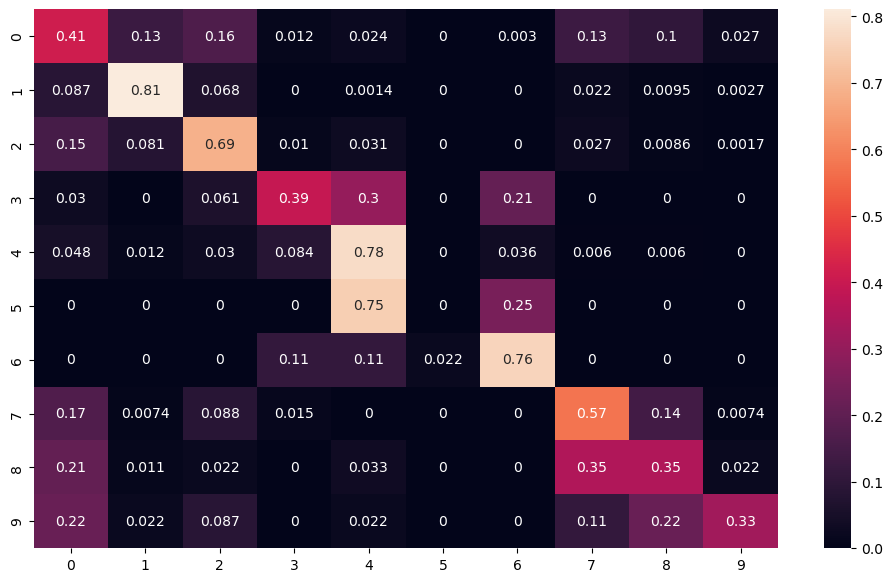

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
# TODO: Evaluate the best validation model on the test set and create a confusion matrix
#model = torch.load('model/best_model', weights_only=False)

for inputs, lbs in test_loader:
    outputs = model(inputs)
    predicts = outputs.argmax(dim=1)

    y_true = lbs.detach().numpy()
    y_pred = predicts.detach().numpy()

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)


### (f)

We can do data augmentation, i.e. rotate images of galaxies to create new dataset, and combine all of these data to train the model.

## 3 Positional Encoding

$ E \in \mathbb{R}^{p\times n} $

$ E_{(2k), i} = \sin\left(i \cdot \exp\left(-\frac{2k \cdot \log(10000)}{p}\right)\right) $

$ E_{(2k+1), i} = \cos\left(i \cdot \exp\left(-\frac{2k \cdot \log(10000)}{p}\right)\right) $

In [1]:
import numpy as np
import matplotlib.pyplot as plt
p = 256
N = 64
E = np.zeros((p, N))
for i in range(E.shape[0]):
    for j in range(E.shape[1]):
        if i % 2 == 0:
            E[i][j] = np.sin(j * np.exp(-i * np.log(10000)/E.shape[0]))
        else:
            E[i][j] = np.cos(j * np.exp(-(i-1) * np.log(10000)/E.shape[0]))

### (b)

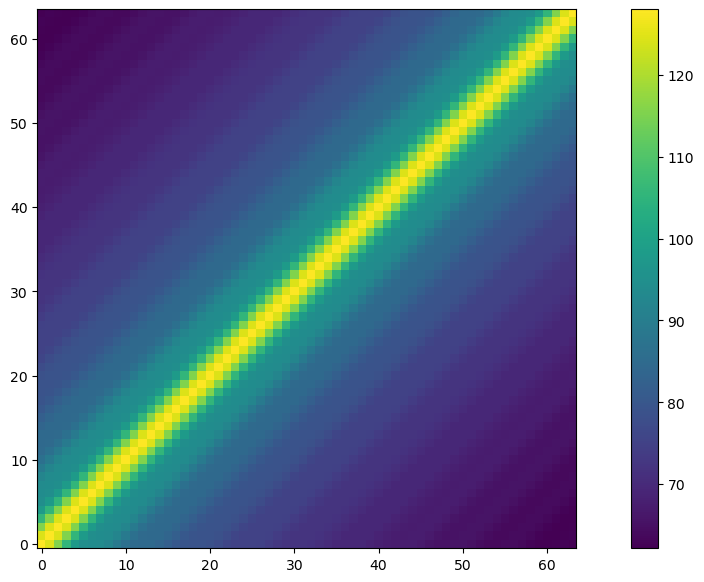

In [8]:
plt.imshow(E.T @ E, origin='lower')
plt.colorbar()

### (c)

In [3]:
X = np.random.random((p, N))
K = X + E
Q = np.concatenate((X, E))

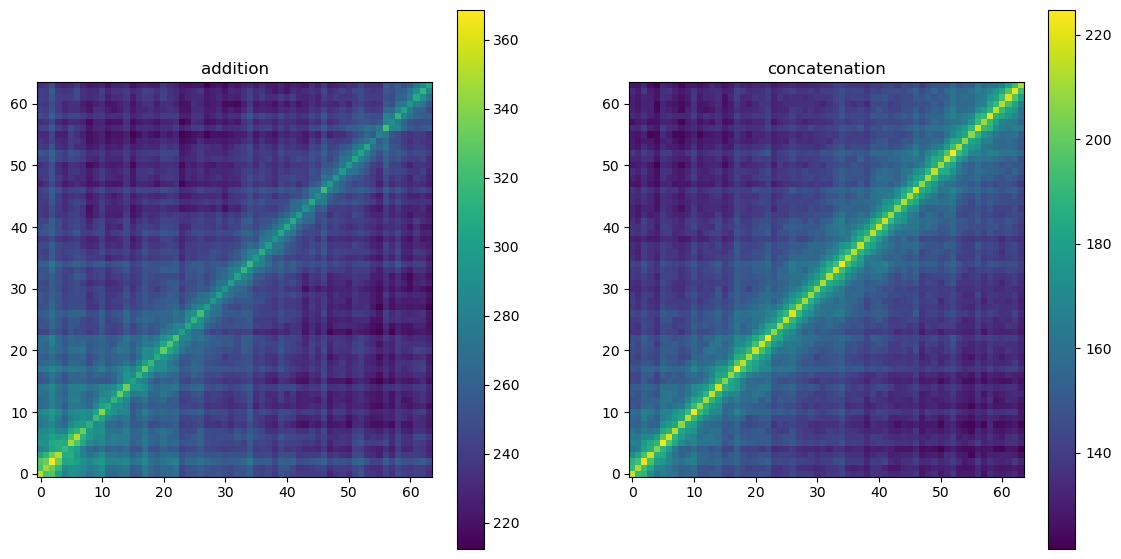

In [7]:
plt.rcParams["figure.figsize"] = (14,7)
plt.subplot(121)
plt.imshow(K.T @ K, origin='lower')
plt.title('addition')
plt.colorbar()
plt.subplot(122)
plt.imshow(Q.T @ Q, origin='lower')
plt.title('concatenation')
plt.colorbar()